# Ingredient Normalizer Beta

In [ ]:
import random
from tqdm import tqdm
from typing import Any, List, Sequence, Tuple
import math
from foodrec.tools.ingredient_normalizer import IngredientNormalisation
from foodrec.data.all_recipe import AllRecipeLoader
from typing import List, Sequence, Set, Union
import math

## Helper Methods

In [ ]:
def introduce_typo(word: str) -> str:
    """Introduce character swap typo"""
    if len(word) < 4:
        return word
    i = random.randint(0, len(word) - 2)
    return word[:i] + word[i+1] + word[i] + word[i+2:]

def drop_random_char(word: str) -> str:
    """Drop a random character"""
    if len(word) < 4:
        return word
    i = random.randint(0, len(word) - 1)
    return word[:i] + word[i+1:]

def add_random_char(word: str) -> str:
    """Add a random character"""
    if len(word) < 3:
        return word
    chars = 'abcdefghijklmnopqrstuvwxyz'
    i = random.randint(0, len(word))
    return word[:i] + random.choice(chars) + word[i:]

def substitute_char(word: str) -> str:
    """Substitute a random character"""
    if len(word) < 3:
        return word
    chars = 'abcdefghijklmnopqrstuvwxyz'
    i = random.randint(0, len(word) - 1)
    return word[:i] + random.choice(chars) + word[i+1:]


def duplicate_char(word: str) -> str:
    """Verdoppelt ein zufälliges Zeichen im Wort (Mehrfachbuchstabenfehler)."""
    if len(word) < 3:
        return word
    i = random.randint(0, len(word) - 1)
    return word[:i] + word[i] + word[i] + word[i+1:]


# einfache Mapping-Tabelle für phonetische Verwechslungen
PHONETIC_MAP = {
    "ph": "f",
    "f": "ph",
    "c": "k",
    "k": "c",
    "s": "z",
    "z": "s",
    "v": "w",
    "w": "v",
    "ch": "k",
    "sh": "sch",
    "sch": "sh",
    "x": "ks",
    "ks": "x",
    "gh": "g",
}

def phonetic_confusion(word: str) -> str:
    """Ersetzt eine phonetisch ähnliche Sequenz im Wort."""
    if len(word) < 3:
        return word
    
    candidates = [k for k in PHONETIC_MAP.keys() if k in word.lower()]
    if not candidates:
        return word 
    
    choice = random.choice(candidates)
    replacement = PHONETIC_MAP[choice]
    
    idx = word.lower().find(choice)
    return word[:idx] + replacement + word[idx+len(choice):]


In [5]:
def get_all_recipe_dataset():
    AL = AllRecipeLoader()
    dataset = AL.load_training_set()
    return dataset

def get_embeddings():
        dataset = get_all_recipe_dataset()
        english_terms = dataset
        ls = []
        for index in range(0, len(english_terms)):
            ls.append([english_terms[index], english_terms[index]])  
        return ls


In [6]:
dataset = get_embeddings()
english_terms = [value[0] for value in dataset]


In [7]:
import numpy as np
evaluation_categories = ['introduce_typo', 'drop_random_char', 'add_random_char', 'substitute_char', 'duplicate_char',  'phonetic_confusion']
def bootstrap_eval(ingredients, B=100, per_cat=2, seed=42):

    rng_master = np.random.default_rng(seed)
    metrics = {cat: [] for cat in ['introduce_typo','drop_random_char','add_random_char','substitute_char']}
    metrics['overall'] = []
    tests = []
    for b in tqdm(range(B), desc="Bootstrapping"):
        rng = np.random.default_rng(rng_master.integers(1<<31))
        # Cluster: ziehe Zutaten mit Zurücklegen
        sample_frac = 0.1  # z.B. 20%
        sampled_ings = rng.choice(ingredients, size=int(sample_frac * len(ingredients)), replace=True)
        # baue Testset (z.B. per_cat Typos je Fehlerart/Zutat)
        sample_ls = []
        for ing in sampled_ings:
            for _ in range(per_cat):
                ing = str(ing)
                sample_ls.append([ing, introduce_typo(ing),  'introduce_typo'])
                sample_ls.append([ing, drop_random_char(ing), 'drop_random_char'])
                sample_ls.append([ing, add_random_char(ing), 'add_random_char'])
                sample_ls.append([ing, substitute_char(ing), 'substitute_char'])
                sample_ls.append([ing, duplicate_char(ing), 'duplicate_char'])
                sample_ls.append([ing, phonetic_confusion(ing), 'phonetic_confusion'])
        tests.append(sample_ls)
    return tests

In [8]:
bootstrat_dataset = bootstrap_eval(english_terms)

Bootstrapping: 100%|██████████| 100/100 [00:00<00:00, 139.78it/s]


In [7]:
len(english_terms)

3184

In [9]:
def _to_float(x: Any) -> float:
    """Sicher zu float konvertieren; None/NaN -> -inf."""
    try:
        v = float(x)
        return float("-inf") if math.isnan(v) else v
    except Exception:
        return float("-inf")

def _is_score(x: Any) -> bool:
    try:
        _ = float(x)
        return True
    except Exception:
        return False

def _is_record(x: Any, index: int) -> bool:
    # Echte Treffer sehen aus wie ['name', score1, ...]
    return (
        isinstance(x, (list, tuple))
        and len(x) > index
        and isinstance(x[0], str)          # Name vorhanden
        and _is_score(x[index])             # Score konvertierbar
    )

In [ ]:
def calculate_best_match(index: int, res, ground_truth: str, label) -> Tuple[Any, float, bool]:
    if not res:
        return (None, None, False)

    candidates: List[Sequence[Any]] = [res] if _is_record(res, index) else [r for r in res if _is_record(r, index)]
    if not candidates:
        return (None, None, False)

    best = max(candidates, key=lambda r: _to_float(r[index]))
    best_score = _to_float(best[index])

    name = best[0]
    ok = name.lower() == str(ground_truth).lower()
    return name, best_score, ok, label


In [27]:
evaluation_categories = ['introduce_typo', 'drop_random_char', 'add_random_char', 'substitute_char']
def evaluator(dataset):
    ingredient_normalizer = IngredientNormalisation()
    ls_batch = []
    id = 0
    for batch in tqdm(dataset, desc="Evaluating batches"):
        sequence_matcher: List[Tuple[Sequence[Any], Any, bool]] = []
        n_gram: List[Tuple[Sequence[Any], Any, bool]] = []
        ls_edit_distance: List[Tuple[Sequence[Any], Any, bool]] = []
        id+=1
        for sample in batch:
            gt, test_case, label = sample
            res = ingredient_normalizer.normalize(test_case, more_information=True)
            sequence_matcher.append(calculate_best_match(1, res, gt, label))
            n_gram.append((res[0][2], 1, res[0][2] == gt, label))
            ls_edit_distance.append(calculate_best_match(3, res, gt, label))
        ls_batch.append({
        "sequence_matcher": sequence_matcher,
        "n_gram": n_gram,
        "ls_edit_distance":  ls_edit_distance,
        })
    return ls_batch

In [28]:
evaluator_dataset = evaluator(bootstrat_dataset)

Evaluating batches: 100%|██████████| 100/100 [16:04<00:00,  9.65s/it]


## Evaluate Ngram Index

In [30]:
len(evaluator_dataset[0]['n_gram'])

3816

In [31]:
ls = []
for batch in evaluator_dataset:
    ls.append(batch['n_gram'])

In [18]:
ab = []
for batch in ls:
    ab.append(sum(batch)/len(batch))


In [19]:
mean_val = np.mean(ab)
lower = np.percentile(ab, 2.5)
upper = np.percentile(ab, 97.5)

print("Mittelwert:", mean_val)
print("2.5%-Quantil:", lower)
print("97.5%-Quantil:", upper)


Mittelwert: 0.7182023060796645
2.5%-Quantil: 0.6719077568134172
97.5%-Quantil: 0.7593618972746331


In [ ]:
GT = Union[int, Set[int], List[int]]

def as_set(x: GT) -> Set[int]:
    return {x} if isinstance(x, int) else set(x)

def precision_at_k(preds: Sequence[int], gt: Set[int], k: int) -> float:
    k = min(k, len(preds))
    if k == 0: return 0.0
    return sum(1 for p in preds[:k] if p in gt) / k

def recall_at_k(preds: Sequence[int], gt: Set[int], k: int) -> float:
    if len(gt) == 0: return 0.0
    return sum(1 for p in preds[:k] if p in gt) / len(gt)

def f1(p: float, r: float) -> float:
    return 0.0 if (p + r) == 0 else 2 * p * r / (p + r)

def reciprocal_rank(preds: Sequence[int], gt: Set[int]) -> float:
    for i, p in enumerate(preds, start=1):
        if p in gt:
            return 1.0 / i
    return 0.0

def average_precision(preds: Sequence[int], gt: Set[int]) -> float:
    """AP über das gesamte Ranking (endliches Ranking)"""
    if len(gt) == 0:
        return 0.0
    hits, s = 0, 0.0
    for i, p in enumerate(preds, start=1):
        if p in gt:
            hits += 1
            s += hits / i
    return 0.0 if hits == 0 else s / min(len(gt), hits)

def evaluate_all(
    all_preds: List[List[int]],
    all_gt: List[GT],
    k: int = 1,
):
    assert len(all_preds) == len(all_gt)
    P, R, F1, RR, AP = [], [], [], [], []
    hits_at_k = 0

    for preds, gt_item in zip(all_preds, all_gt):
        gt = as_set(gt_item)
        p = precision_at_k(preds, gt, k)
        r = recall_at_k(preds, gt, k)
        P.append(p); R.append(r); F1.append(f1(p, r))
        RR.append(reciprocal_rank(preds, gt))
        AP.append(average_precision(preds, gt))
        hits_at_k += 1 if any(p in gt for p in preds[:k]) else 0

    results = {
        f"precision@{k}": sum(P) / len(P),
        f"recall@{k}":    sum(R) / len(R),
        f"f1@{k}":        sum(F1) / len(F1),
        f"hits@{k}":      hits_at_k / len(all_preds),  
        "MRR":            sum(RR) / len(RR),
        "MAP":            sum(AP) / len(AP),
    }
    return results

## Evaluate others

In [ ]:
def visualize_bootstrap(ls_batch):
    """
    Visualisiert Metriken über Bootstrap-Batches und berechnet Min/Max-Accuracy pro Batch.

    Eingabe:
        ls_batch: Output deiner evaluator()-Funktion (Liste von Dicts mit Keys:
                  "ls_fuzzy_score", "ls_partial_score", "ls_jaro_winkler", "ls_edit_distance";
                  Werte: Listen von Triples (name, score, ok))

    Wirkung:
        - Plots pro Batch für Accuracy, Precision, Recall, F1 (alle vier Scorer)
        - Plot der Min- und Max-Accuracy pro Batch (über alle Scorer)
        - Boxplot der Accuracy-Verteilung je Scorer

    Rückgabe:
        {
          "results":   <Dict mit summary/per_batch/pooled_overall je Scorer>,
          "df":        <pandas.DataFrame mit Accuracy je Scorer und min_accuracy/max_accuracy pro Batch>,
          "figs":      <Liste der Matplotlib-Figure-Objekte (in Plot-Reihenfolge)>
        }
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.metrics import precision_score, recall_score, f1_score
    from typing import Dict, Any, List

    KEYS = ["sequence_matcher",  "ls_edit_distance"]

    def _batch_metrics(triples: List[tuple]) -> Dict[str, float]:
        scores, y_pred = [], []
        for _, sc, ok, label in triples:
            if sc is None:
                continue
            scores.append(float(sc))
            y_pred.append(1 if ok else 0)

        if not y_pred:
            return dict(n=0, accuracy=np.nan, precision=np.nan, recall=np.nan, f1=np.nan,
                        mean_conf_true=np.nan, mean_conf_wrong=np.nan, mean_conf_all=np.nan)

        t = 0.8
        y_true = np.array([1 if ok else 0 for _, sc, ok, label in triples if sc is not None])
        y_pred = np.array([1 if float(sc) >= t else 0 for _, sc, ok, label in triples if sc is not None])


        acc = float(y_pred.mean())
        prec = float(precision_score(y_true, y_pred, zero_division=0))
        rec = float(recall_score(y_true, y_pred, zero_division=0))
        f1 = float(f1_score(y_true, y_pred, zero_division=0))

        scores_true = [s for s, o in zip(scores, y_pred) if o == 1]
        scores_wrong = [s for s, o in zip(scores, y_pred) if o == 0]

        return dict(
            n=int(len(y_pred)),
            accuracy=acc, precision=prec, recall=rec, f1=f1,
            mean_conf_true=float(np.mean(scores_true)) if scores_true else np.nan,
            mean_conf_wrong=float(np.mean(scores_wrong)) if scores_wrong else np.nan,
            mean_conf_all=float(np.mean(scores)) if scores else np.nan,
        )

    def _agg_ci(values: List[float]) -> Dict[str, float]:
        vals = np.array([v for v in values if not (v is None or np.isnan(v))], dtype=float)
        if vals.size == 0:
            return {"mean": np.nan, "std": np.nan, "ci95_low": np.nan, "ci95_high": np.nan}
        return {
            "mean": float(np.mean(vals)),
            "std": float(np.std(vals, ddof=1)) if vals.size > 1 else 0.0,
            "ci95_low": float(np.percentile(vals, 2.5)),
            "ci95_high": float(np.percentile(vals, 97.5)),
        }

    results: Dict[str, Any] = {}
    for key in KEYS:
        per_batch = []
        pooled_scores, pooled_preds = [], []

        for batch in ls_batch:
            triples = batch.get(key, [])
            m = _batch_metrics(triples)
            per_batch.append(m)
            for _, sc, ok, label in triples:
                if sc is None:
                    continue
                pooled_scores.append(float(sc))
                pooled_preds.append(1 if ok else 0)

        summary = {
            "n_batches": len(ls_batch),
            "n_nonempty_batches": int(sum(1 for b in per_batch if b["n"] > 0)),
            "accuracy": _agg_ci([b["accuracy"] for b in per_batch]),
            "precision": _agg_ci([b["precision"] for b in per_batch]),
            "recall": _agg_ci([b["recall"] for b in per_batch]),
            "f1": _agg_ci([b["f1"] for b in per_batch]),
            "mean_conf_true": _agg_ci([b["mean_conf_true"] for b in per_batch]),
            "mean_conf_wrong": _agg_ci([b["mean_conf_wrong"] for b in per_batch]),
            "mean_conf_all": _agg_ci([b["mean_conf_all"] for b in per_batch]),
        }

        if pooled_preds:
            pooled_preds = np.asarray(pooled_preds, dtype=int)
            y_true = np.ones_like(pooled_preds)
            pooled_overall = {
                "n": int(len(pooled_preds)),
                "accuracy": float(pooled_preds.mean()),
                "precision": float(precision_score(y_true, pooled_preds, zero_division=0)),
                "recall": float(recall_score(y_true, pooled_preds, zero_division=0)),
                "f1": float(f1_score(y_true, pooled_preds, zero_division=0)),
                "mean_conf_true": float(np.mean([s for s, o in zip(pooled_scores, pooled_preds) if o == 1])) if np.any(pooled_preds == 1) else np.nan,
                "mean_conf_wrong": float(np.mean([s for s, o in zip(pooled_scores, pooled_preds) if o == 0])) if np.any(pooled_preds == 0) else np.nan,
                "mean_conf_all": float(np.mean(pooled_scores)) if pooled_scores else np.nan,
            }
        else:
            pooled_overall = dict(n=0, accuracy=np.nan, precision=np.nan, recall=np.nan, f1=np.nan,
                                  mean_conf_true=np.nan, mean_conf_wrong=np.nan, mean_conf_all=np.nan)

        results[key] = {"summary": summary, "per_batch": per_batch, "pooled_overall": pooled_overall}

    acc_series = {k: [b["accuracy"] for b in v["per_batch"]] for k, v in results.items()}
    n_batches = len(next(iter(acc_series.values()))) if acc_series else 0
    df = pd.DataFrame(acc_series)
    if n_batches:
        df.index = np.arange(1, n_batches + 1)
        df.index.name = "batch"
    df["min_accuracy"] = df.min(axis=1, numeric_only=True)
    df["max_accuracy"] = df.max(axis=1, numeric_only=True)

    figs = []

    def _plot_metric(metric: str, title: str):
        fig = plt.figure()
        xs = np.arange(1, n_batches + 1)
        for label, vals in {k: [b[metric] for b in v["per_batch"]] for k, v in results.items()}.items():
            plt.plot(xs, vals, marker='o', label=label)
        plt.xlabel("Batch")
        plt.ylabel(metric.capitalize())
        plt.title(title)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        figs.append(fig)

    if n_batches > 0:
        _plot_metric("accuracy", "Accuracy je Batch")
        _plot_metric("precision", "Precision je Batch")
        _plot_metric("recall", "Recall je Batch")
        _plot_metric("f1", "F1-Score je Batch")

        fig = plt.figure()
        xs = np.arange(1, n_batches + 1)
        all_acc = np.vstack([acc_series[k] for k in acc_series.keys()])  # (methods, batches)
        min_per_batch = np.nanmin(all_acc, axis=0)
        max_per_batch = np.nanmax(all_acc, axis=0)
        plt.plot(xs, min_per_batch, marker='o', label="min accuracy")
        plt.plot(xs, max_per_batch, marker='o', label="max accuracy")
        plt.xlabel("Batch")
        plt.ylabel("Accuracy")
        plt.title("Min/Max Accuracy pro Batch (über alle Scorer)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        figs.append(fig)

        fig = plt.figure()
        plt.boxplot([acc_series[k] for k in acc_series.keys()], labels=list(acc_series.keys()), showmeans=True)
        plt.ylabel("Accuracy")
        plt.title("Accuracy-Verteilung je Scorer über Batches")
        plt.grid(True, axis='y')
        plt.tight_layout()
        figs.append(fig)

    return {"results": results, "df": df, "figs": figs}


In [ ]:
def visualize_bootstrap(ls_batch):
    """
    Visualisiert Metriken über Bootstrap-Batches und berechnet Min/Max-Accuracy pro Batch.
    Neu: Zusätzliche Auswertung pro Fehler-Kategorie (Label) je Scorer.

    Eingabe:
        ls_batch: Output deiner evaluator()-Funktion (Liste von Dicts mit Keys:
                  "ls_fuzzy_score", "ls_partial_score", "ls_jaro_winkler", "ls_edit_distance";
                  Werte: Listen von Quadruples (name, score, ok, label))

    Wirkung:
        - Plots pro Batch für Accuracy, Precision, Recall, F1 (alle vier Scorer)
        - Plot der Min- und Max-Accuracy pro Batch (über alle Scorer)
        - Boxplot der Accuracy-Verteilung je Scorer
        - NEU: Heatmap mittlere Accuracy (Scorer × Kategorie)
        - NEU: Pro Kategorie ein Plot "Accuracy je Batch" über alle Scorer

    Rückgabe:
        {
          "results":   <Dict mit summary/per_batch/pooled_overall je Scorer
                        und NEU: by_category[category] mit denselben Feldern>,
          "df":        <pandas.DataFrame mit Accuracy je Scorer und min_accuracy/max_accuracy pro Batch>,
          "df_by_category": <pandas.DataFrame mit Accuracy je (Scorer, Kategorie) pro Batch>,
          "figs":      <Liste der Matplotlib-Figure-Objekte (in Plot-Reihenfolge)>
        }
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.metrics import precision_score, recall_score, f1_score
    from typing import Dict, Any, List, Tuple, DefaultDict
    from collections import defaultdict

    KEYS = ["sequence_matcher",  "ls_edit_distance","n_gram"]
    EVAL_CATEGORIES = ['introduce_typo', 'drop_random_char', 'add_random_char',
                       'substitute_char', 'duplicate_char', 'phonetic_confusion']

    # ---------- helpers ----------
    def _batch_metrics(triples: List[Tuple[str, float, bool, str]]) -> Dict[str, float]:
        scores, y_pred = [], []
        for _, sc, ok, _ in triples:
            if sc is None:
                continue
            scores.append(float(sc))
            y_pred.append(1 if ok else 0)

        if not y_pred:
            return dict(n=0, accuracy=np.nan, precision=np.nan, recall=np.nan, f1=np.nan,
                        mean_conf_true=np.nan, mean_conf_wrong=np.nan, mean_conf_all=np.nan)

        t = 0.8
        y_true = np.array([1 if ok else 0 for _, sc, ok, _ in triples if sc is not None], dtype=int)
        y_hat  = np.array([1 if float(sc) >= t else 0 for _, sc, ok, _ in triples if sc is not None], dtype=int)

        acc = float((y_hat == y_true).mean())  # echte Accuracy
        prec = float(precision_score(y_true, y_hat, zero_division=0))
        rec  = float(recall_score(y_true, y_hat, zero_division=0))
        f1   = float(f1_score(y_true, y_hat, zero_division=0))

        scores_true  = [s for s, o in zip(scores, y_hat) if o == 1]
        scores_wrong = [s for s, o in zip(scores, y_hat) if o == 0]

        return dict(
            n=int(len(y_true)),
            accuracy=acc, precision=prec, recall=rec, f1=f1,
            mean_conf_true=float(np.mean(scores_true)) if scores_true else np.nan,
            mean_conf_wrong=float(np.mean(scores_wrong)) if scores_wrong else np.nan,
            mean_conf_all=float(np.mean(scores)) if scores else np.nan,
        )

    def _agg_ci(values: List[float]) -> Dict[str, float]:
        vals = np.array([v for v in values if not (v is None or (isinstance(v, float) and np.isnan(v)))], dtype=float)
        if vals.size == 0:
            return {"mean": np.nan, "std": np.nan, "ci95_low": np.nan, "ci95_high": np.nan}
        return {
            "mean": float(np.mean(vals)),
            "std": float(np.std(vals, ddof=1)) if vals.size > 1 else 0.0,
            "ci95_low": float(np.percentile(vals, 2.5)),
            "ci95_high": float(np.percentile(vals, 97.5)),
        }

    results: Dict[str, Any] = {}
    for key in KEYS:
        per_batch = []
        pooled_scores, pooled_preds, pooled_true = [], [], []

        per_batch_by_cat: List[Dict[str, Dict[str, float]]] = []
        pooled_by_cat_scores: DefaultDict[str, List[float]] = defaultdict(list)
        pooled_by_cat_true:   DefaultDict[str, List[int]]   = defaultdict(list)
        pooled_by_cat_pred:   DefaultDict[str, List[int]]   = defaultdict(list)

        for batch in ls_batch:
            triples = batch.get(key, [])
            m = _batch_metrics(triples)
            per_batch.append(m)

            cat_metrics = {}
            cats_in_batch = sorted(set([lbl for *_, lbl in triples if triples]))
            cats_iter = EVAL_CATEGORIES if EVAL_CATEGORIES else cats_in_batch
            for cat in cats_iter:
                triples_cat = [t for t in triples if len(t) >= 4 and t[3] == cat]
                cat_metrics[cat] = _batch_metrics(triples_cat)
                for _, sc, ok, _ in triples_cat:
                    if sc is None:
                        continue
                    pooled_by_cat_scores[cat].append(float(sc))
                    pooled_by_cat_true[cat].append(1 if ok else 0)
                    pooled_by_cat_pred[cat].append(1 if float(sc) >= 0.8 else 0)

            per_batch_by_cat.append(cat_metrics)

            for _, sc, ok, _ in triples:
                if sc is None:
                    continue
                pooled_scores.append(float(sc))
                pooled_true.append(1 if ok else 0)
                pooled_preds.append(1 if float(sc) >= 0.8 else 0)

        summary = {
            "n_batches": len(ls_batch),
            "n_nonempty_batches": int(sum(1 for b in per_batch if b["n"] > 0)),
            "accuracy": _agg_ci([b["accuracy"] for b in per_batch]),
            "precision": _agg_ci([b["precision"] for b in per_batch]),
            "recall": _agg_ci([b["recall"] for b in per_batch]),
            "f1": _agg_ci([b["f1"] for b in per_batch]),
            "mean_conf_true": _agg_ci([b["mean_conf_true"] for b in per_batch]),
            "mean_conf_wrong": _agg_ci([b["mean_conf_wrong"] for b in per_batch]),
            "mean_conf_all": _agg_ci([b["mean_conf_all"] for b in per_batch]),
        }

        if pooled_true:
            y_true = np.asarray(pooled_true, dtype=int)
            y_hat  = np.asarray(pooled_preds, dtype=int)
            pooled_overall = {
                "n": int(len(y_true)),
                "accuracy": float((y_hat == y_true).mean()),
                "precision": float(precision_score(y_true, y_hat, zero_division=0)),
                "recall": float(recall_score(y_true, y_hat, zero_division=0)),
                "f1": float(f1_score(y_true, y_hat, zero_division=0)),
                "mean_conf_true": float(np.mean([s for s, o in zip(pooled_scores, y_hat) if o == 1])) if np.any(y_hat == 1) else np.nan,
                "mean_conf_wrong": float(np.mean([s for s, o in zip(pooled_scores, y_hat) if o == 0])) if np.any(y_hat == 0) else np.nan,
                "mean_conf_all": float(np.mean(pooled_scores)) if pooled_scores else np.nan,
            }
        else:
            pooled_overall = dict(n=0, accuracy=np.nan, precision=np.nan, recall=np.nan, f1=np.nan,
                                  mean_conf_true=np.nan, mean_conf_wrong=np.nan, mean_conf_all=np.nan)

        by_category: Dict[str, Any] = {}
        cats_all = EVAL_CATEGORIES
        for cat in cats_all:
            cat_per_batch = []
            for cmb in per_batch_by_cat:
                if cat in cmb:
                    cat_per_batch.append(cmb[cat])
                else:
                    cat_per_batch.append(dict(n=0, accuracy=np.nan, precision=np.nan, recall=np.nan, f1=np.nan,
                                              mean_conf_true=np.nan, mean_conf_wrong=np.nan, mean_conf_all=np.nan))
            cat_summary = {
                "n_batches": len(cat_per_batch),
                "n_nonempty_batches": int(sum(1 for b in cat_per_batch if b["n"] > 0)),
                "accuracy": _agg_ci([b["accuracy"] for b in cat_per_batch]),
                "precision": _agg_ci([b["precision"] for b in cat_per_batch]),
                "recall": _agg_ci([b["recall"] for b in cat_per_batch]),
                "f1": _agg_ci([b["f1"] for b in cat_per_batch]),
                "mean_conf_true": _agg_ci([b["mean_conf_true"] for b in cat_per_batch]),
                "mean_conf_wrong": _agg_ci([b["mean_conf_wrong"] for b in cat_per_batch]),
                "mean_conf_all": _agg_ci([b["mean_conf_all"] for b in cat_per_batch]),
            }
            pt = np.asarray(pooled_by_cat_true.get(cat, []), dtype=int) if pooled_by_cat_true.get(cat) else None
            ph = np.asarray(pooled_by_cat_pred.get(cat, []), dtype=int) if pooled_by_cat_pred.get(cat) else None
            ps = pooled_by_cat_scores.get(cat, [])
            if pt is not None and pt.size:
                by_cat_pooled = {
                    "n": int(pt.size),
                    "accuracy": float((ph == pt).mean()),
                    "precision": float(precision_score(pt, ph, zero_division=0)),
                    "recall": float(recall_score(pt, ph, zero_division=0)),
                    "f1": float(f1_score(pt, ph, zero_division=0)),
                    "mean_conf_true": float(np.mean([s for s, o in zip(ps, ph) if o == 1])) if np.any(ph == 1) else np.nan,
                    "mean_conf_wrong": float(np.mean([s for s, o in zip(ps, ph) if o == 0])) if np.any(ph == 0) else np.nan,
                    "mean_conf_all": float(np.mean(ps)) if ps else np.nan,
                }
            else:
                by_cat_pooled = dict(n=0, accuracy=np.nan, precision=np.nan, recall=np.nan, f1=np.nan,
                                     mean_conf_true=np.nan, mean_conf_wrong=np.nan, mean_conf_all=np.nan)

            by_category[cat] = {"summary": cat_summary,
                                "per_batch": cat_per_batch,
                                "pooled_overall": by_cat_pooled}

        results[key] = {
            "summary": summary,
            "per_batch": per_batch,
            "pooled_overall": pooled_overall,
            "by_category": by_category,   # <-- NEU
        }
    acc_series = {k: [b["accuracy"] for b in v["per_batch"]] for k, v in results.items()}
    n_batches = len(next(iter(acc_series.values()))) if acc_series else 0
    df = pd.DataFrame(acc_series)
    if n_batches:
        df.index = np.arange(1, n_batches + 1)
        df.index.name = "batch"
    df["min_accuracy"] = df.min(axis=1, numeric_only=True)
    df["max_accuracy"] = df.max(axis=1, numeric_only=True)

    tuples = []
    data = {}
    for scorer, res in results.items():
        for cat in EVAL_CATEGORIES:
            tuples.append((scorer, cat))
            data[(scorer, cat)] = [b["accuracy"] for b in res["by_category"][cat]["per_batch"]]
    if tuples:
        columns = pd.MultiIndex.from_tuples(tuples, names=["scorer", "category"])
        df_by_category = pd.DataFrame(data, columns=columns, index=np.arange(1, n_batches + 1) if n_batches else None)
        if n_batches:
            df_by_category.index.name = "batch"
    else:
        df_by_category = pd.DataFrame()

    figs = []

    def _plot_metric(metric: str, title: str):
        fig = plt.figure()
        xs = np.arange(1, n_batches + 1)
        for label, vals in {k: [b[metric] for b in v["per_batch"]] for k, v in results.items()}.items():
            plt.plot(xs, vals, marker='o', label=label)
        plt.xlabel("Batch")
        plt.ylabel(metric.capitalize())
        plt.title(title)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        figs.append(fig)

    if n_batches > 0:
        _plot_metric("accuracy", "Accuracy je Batch")
        _plot_metric("precision", "Precision je Batch")
        _plot_metric("recall", "Recall je Batch")
        _plot_metric("f1", "F1-Score je Batch")

        fig = plt.figure()
        xs = np.arange(1, n_batches + 1)
        all_acc = np.vstack([acc_series[k] for k in acc_series.keys()])  # (methods, batches)
        min_per_batch = np.nanmin(all_acc, axis=0)
        max_per_batch = np.nanmax(all_acc, axis=0)
        plt.plot(xs, min_per_batch, marker='o', label="min accuracy")
        plt.plot(xs, max_per_batch, marker='o', label="max accuracy")
        plt.xlabel("Batch")
        plt.ylabel("Accuracy")
        plt.title("Min/Max Accuracy pro Batch (über alle Scorer)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        figs.append(fig)

        fig = plt.figure()
        plt.boxplot([acc_series[k] for k in acc_series.keys()], labels=list(acc_series.keys()), showmeans=True)
        plt.ylabel("Accuracy")
        plt.title("Accuracy-Verteilung je Scorer über Batches")
        plt.grid(True, axis='y')
        plt.tight_layout()
        figs.append(fig)

        fig = plt.figure()
        cats = EVAL_CATEGORIES
        scorers = list(results.keys())
        mat = np.zeros((len(scorers), len(cats))) * np.nan
        for i, sc in enumerate(scorers):
            for j, cat in enumerate(cats):
                mat[i, j] = results[sc]["by_category"][cat]["summary"]["accuracy"]["mean"]
        im = plt.imshow(mat, aspect='auto')
        plt.colorbar(im, fraction=0.046, pad=0.04)
        plt.xticks(ticks=np.arange(len(cats)), labels=cats, rotation=30, ha='right')
        plt.yticks(ticks=np.arange(len(scorers)), labels=scorers)
        plt.title("Accuracy per Test")
        plt.tight_layout()
        figs.append(fig)

        xs = np.arange(1, n_batches + 1)
        for cat in EVAL_CATEGORIES:
            fig = plt.figure()
            for sc in results.keys():
                ys = [b["accuracy"] for b in results[sc]["by_category"][cat]["per_batch"]]
                plt.plot(xs, ys, marker='o', label=sc)
            plt.xlabel("Batch")
            plt.ylabel("Accuracy")
            plt.title(f"Accuracy per Batch – Category: {cat}")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            figs.append(fig)

    def plot_pr_curves(ls_batch, categories=None, threshold=0.8):
        """
        Zeichnet Precision-Recall-Kurven und berechnet AUC-PR (Average Precision) je Scorer.
        Optional auch pro Kategorie (label).

        Eingabe:
            ls_batch: Liste von Dicts (Batches) wie in deiner visualize_bootstrap-Doku,
                    Keys je Scorer: "ls_fuzzy_score", "ls_sequence_match", "ls_jaro_winkler", "ls_edit_distance"
                    Werte: Liste von Tupeln (name, score, ok, label)
            categories: Liste der Kategorien; wenn None -> aus Daten abgeleitet
            threshold: nur für Referenzlinie (nicht für AUC nötig)

        Rückgabe:
            {
            "auc_pr": {scorer: float, ...},
            "auc_pr_by_category": {category: {scorer: float, ...}, ...},
            "figs": [matplotlib.figure.Figure, ...]
            }
        """
        import numpy as np
        import matplotlib.pyplot as plt
        from sklearn.metrics import precision_recall_curve, average_precision_score

        KEYS = ["sequence_matcher", "ls_edit_distance"]

        def pooled_truth_scores(ls_batch, key):
            scores, y_true, cats = [], [], []
            for batch in ls_batch:
                for tup in batch.get(key, []):
                    # erwartet (name, score, ok, label)
                    if tup is None or len(tup) < 4:
                        continue
                    _, sc, ok, lbl = tup
                    if sc is None:
                        continue
                    scores.append(float(sc))
                    y_true.append(1 if ok else 0)
                    cats.append(lbl)
            return np.asarray(y_true, dtype=int), np.asarray(scores, dtype=float), np.asarray(cats, dtype=object)

        figs = []
        auc_pr = {}
        auc_pr_by_category = {}

        fig_all = plt.figure()
        for key in KEYS:
            y_true, scores, _ = pooled_truth_scores(ls_batch, key)
            if y_true.size == 0:
                continue
            prec, rec, _ = precision_recall_curve(y_true, scores)
            ap = average_precision_score(y_true, scores)
            auc_pr[key] = float(ap)
            # eine Linie pro Scorer
            plt.plot(rec, prec, label=f"{key} (AP={ap:.3f})")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision–Recall-curve (overall)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        figs.append(fig_all)

        if categories is None:
            cats_all = set()
            for key in KEYS:
                yt, _, cats = pooled_truth_scores(ls_batch, key)
                if yt.size:
                    cats_all.update(list(cats))
            categories = sorted(list(cats_all))

        for cat in categories:
            if cat is None:
                continue
            fig_cat = plt.figure()
            empty = True
            auc_pr_by_category.setdefault(cat, {})
            for key in KEYS:
                y_true, scores, cats = pooled_truth_scores(ls_batch, key)
                if y_true.size == 0:
                    continue
                mask = (cats == cat)
                if not np.any(mask):
                    continue
                prec, rec, _ = precision_recall_curve(y_true[mask], scores[mask])
                ap = average_precision_score(y_true[mask], scores[mask])
                auc_pr_by_category[cat][key] = float(ap)
                plt.plot(rec, prec, label=f"{key} (AP={ap:.3f})")
                empty = False
            if not empty:
                plt.xlabel("Recall")
                plt.ylabel("Precision")
                plt.title(f"Precision–Recall-Kurven – Kategorie: {cat}")
                plt.grid(True)
                plt.legend()
                plt.tight_layout()
                figs.append(fig_cat)

        return {"auc_pr": auc_pr, "auc_pr_by_category": auc_pr_by_category, "figs": figs}

    plot_pr_curves(ls_batch)
    return {
        "results": results,
        "df": df,
        "df_by_category": df_by_category,  # <-- NEU
        "figs": figs
    }


/var/folders/6n/knlq_sss74g85w6tq1mnlfk40000gn/T/ipykernel_47859/2473949889.py:278: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([acc_series[k] for k in acc_series.keys()], labels=list(acc_series.keys()), showmeans=True)


KeyError: 'ls_jaro_winkler'

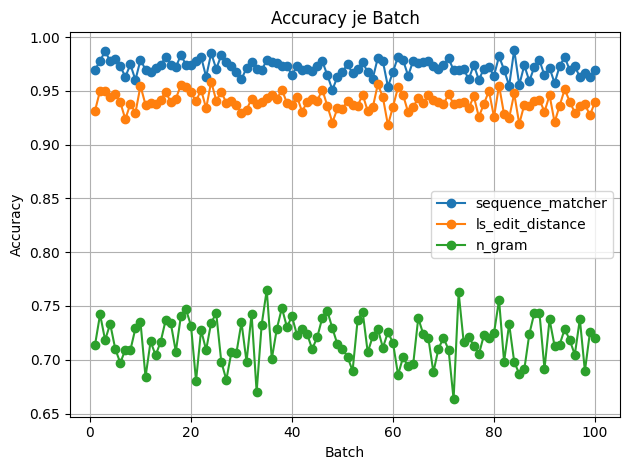

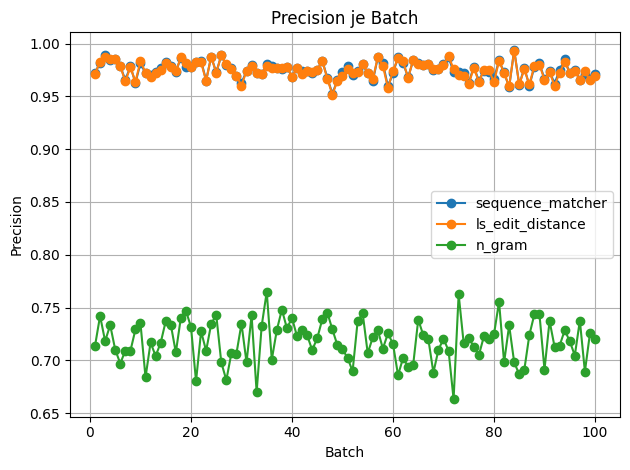

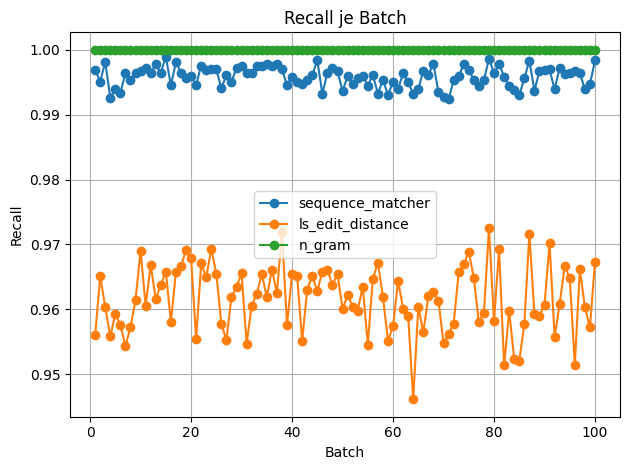

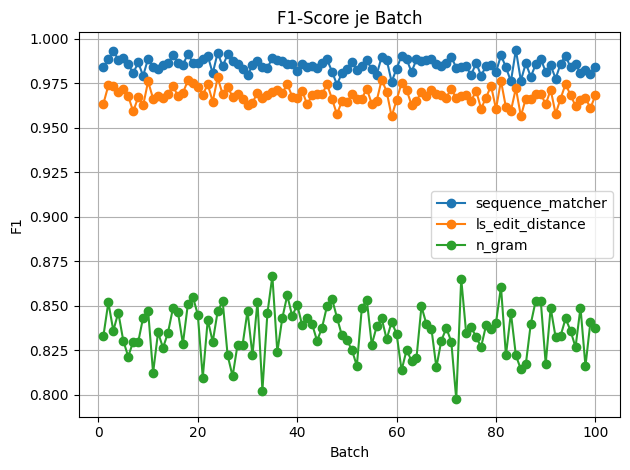

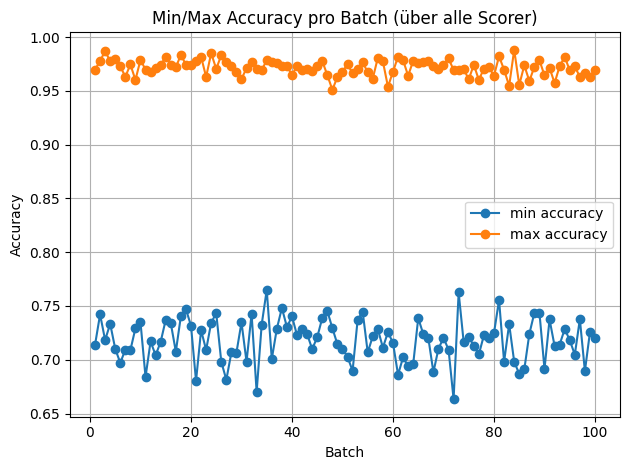

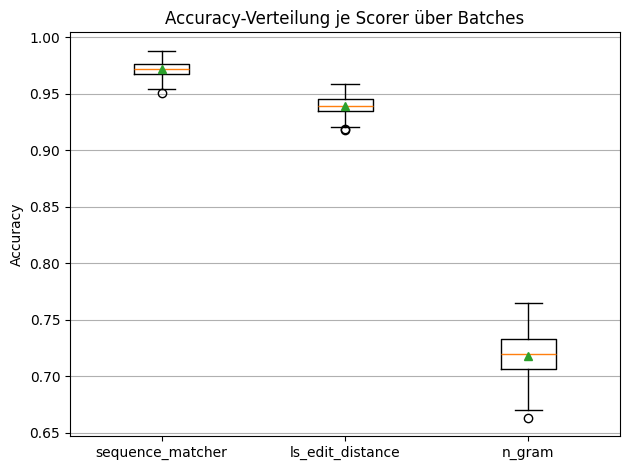

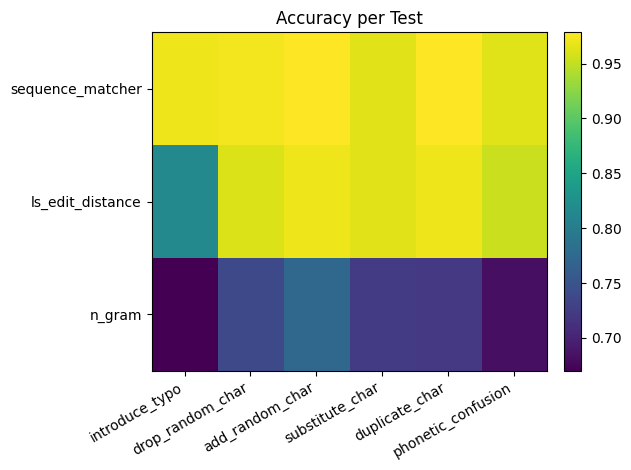

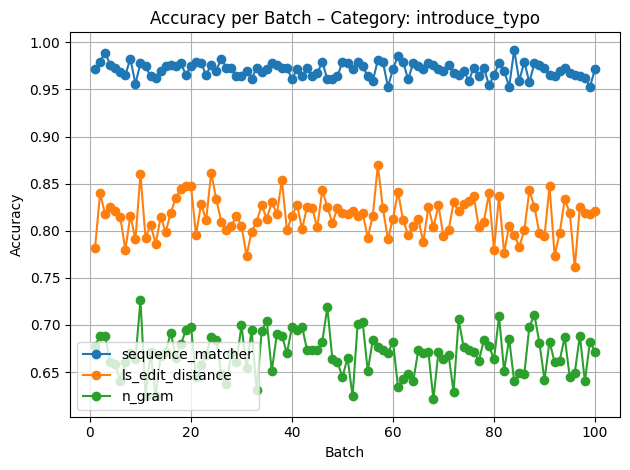

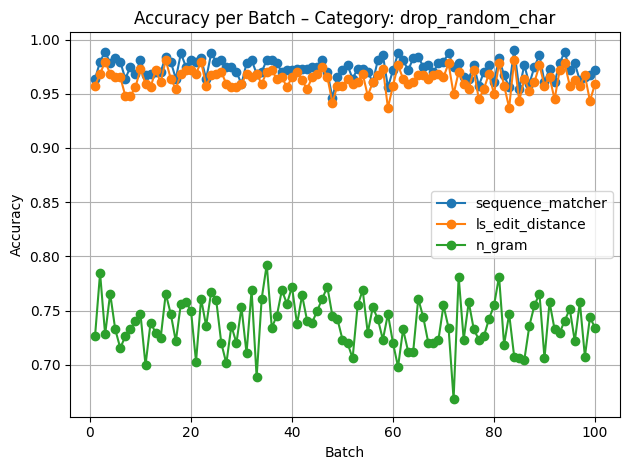

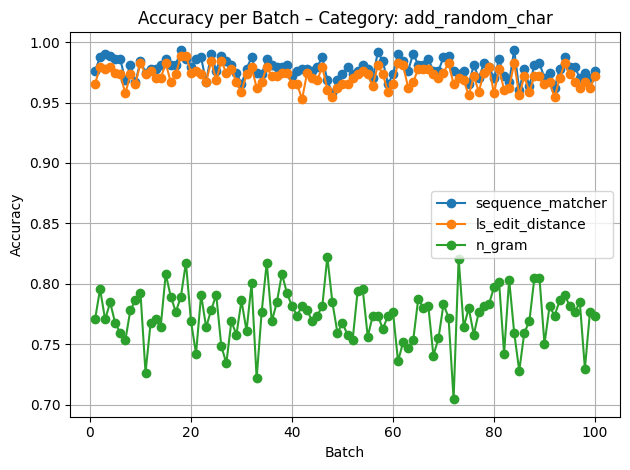

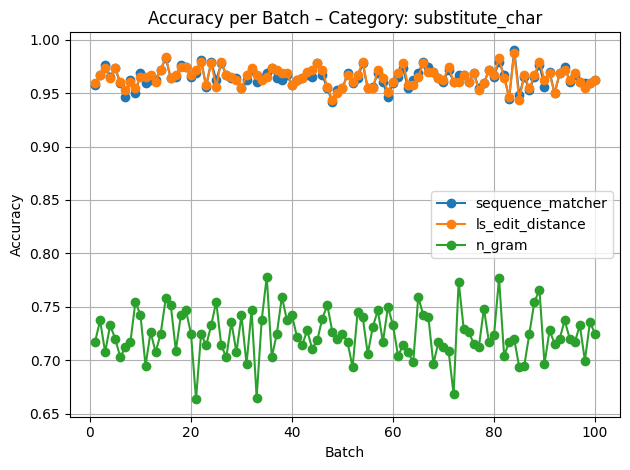

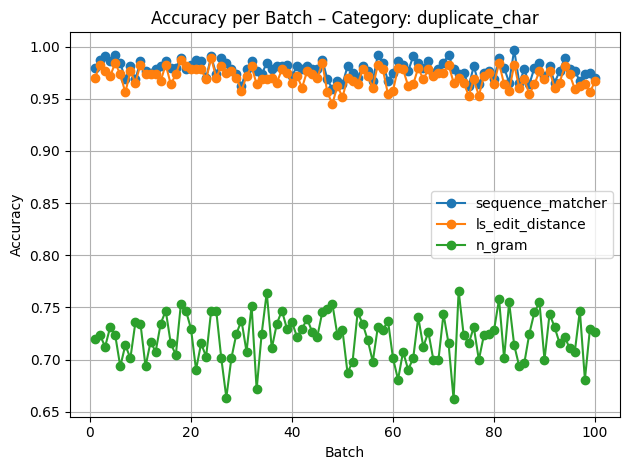

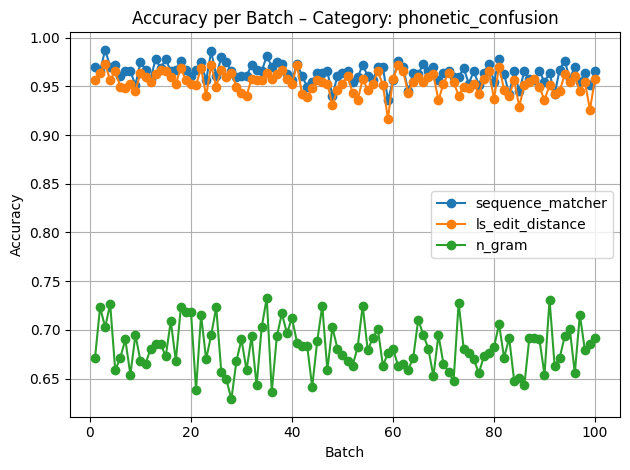

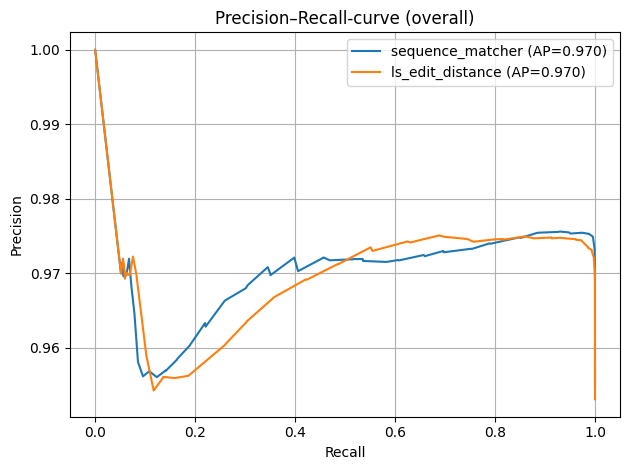

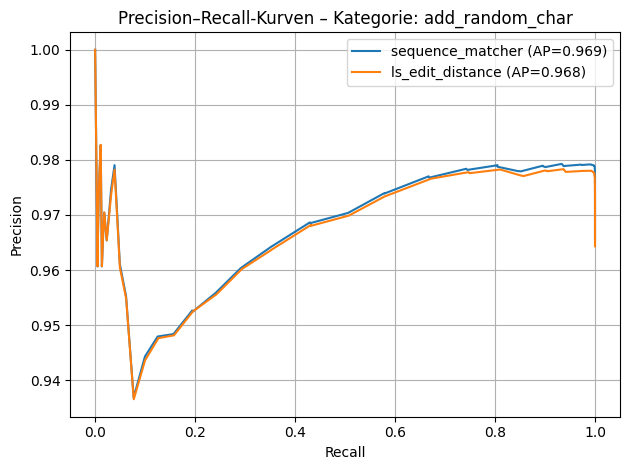

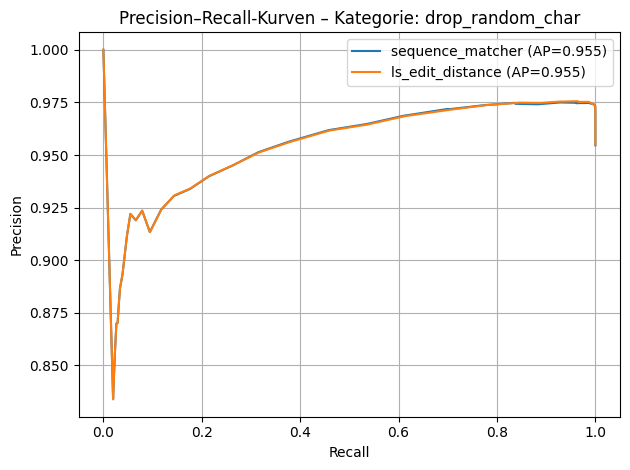

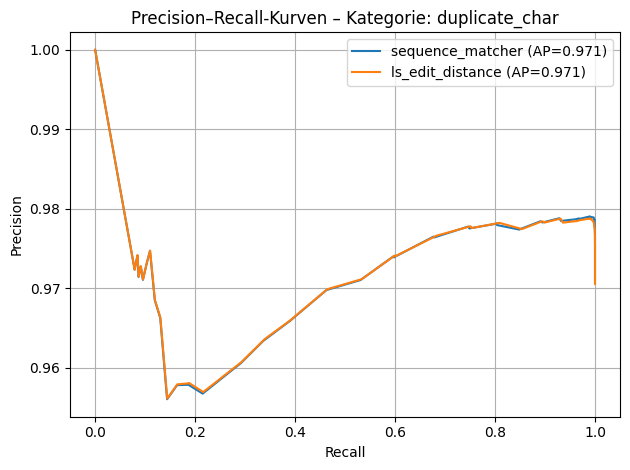

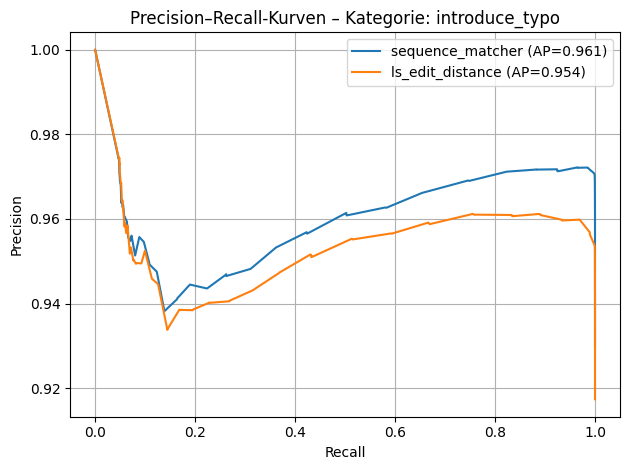

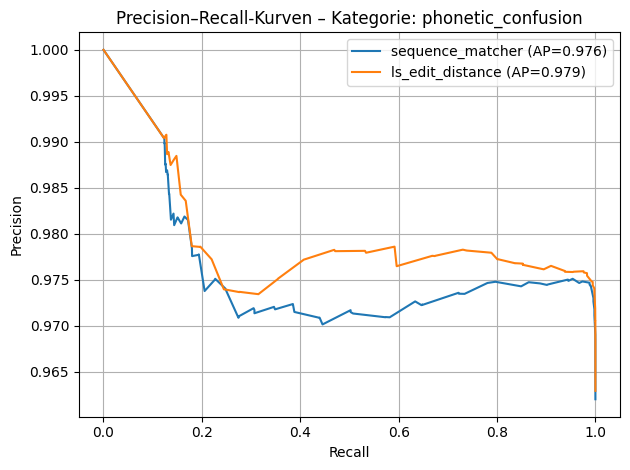

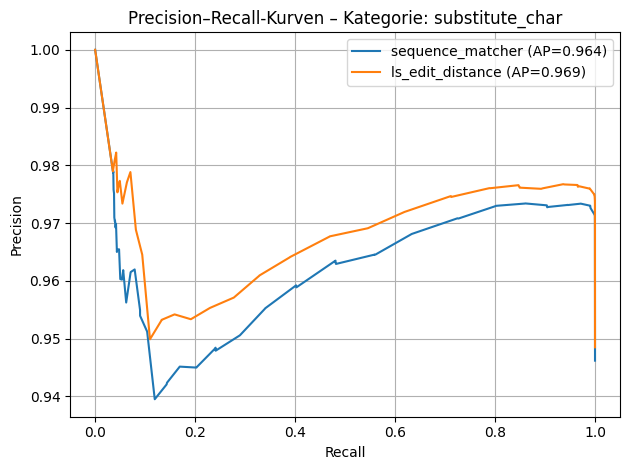

In [ ]:
out = visualize_bootstrap(evaluator_dataset)

In [22]:
out["results"]["ls_fuzzy_score"]["summary"]     # CI-Übersicht


{'n_batches': 100,
 'n_nonempty_batches': 100,
 'accuracy': {'mean': 0.883527253668763,
  'std': 0.01165779919664391,
  'ci95_low': 0.8638037211740042,
  'ci95_high': 0.905712788259958},
 'precision': {'mean': 0.9757742425770656,
  'std': 0.008174254342232914,
  'ci95_low': 0.9581303689350271,
  'ci95_high': 0.9909549179938398},
 'recall': {'mean': 0.9003383204955524,
  'std': 0.009800790583778753,
  'ci95_low': 0.8843069247262716,
  'ci95_high': 0.9197490422351015},
 'f1': {'mean': 0.9365012120498349,
  'std': 0.006871332035873462,
  'ci95_low': 0.9245941813359763,
  'ci95_high': 0.9494821032131319},
 'mean_conf_true': {'mean': 0.8557413924078151,
  'std': 0.0009292068325829806,
  'ci95_low': 0.8540992036225928,
  'ci95_high': 0.8577054359979502},
 'mean_conf_wrong': {'mean': 0.7123852422748009,
  'std': 0.011178189456678759,
  'ci95_low': 0.692623742716328,
  'ci95_high': 0.7330029610237757},
 'mean_conf_all': {'mean': 0.838635755046908,
  'std': 0.0026277244179767683,
  'ci95_low': 

In [23]:
out["results"]["ls_edit_distance"]["summary"]          # CI über Batches

{'n_batches': 100,
 'n_nonempty_batches': 100,
 'accuracy': {'mean': 0.9402437106918239,
  'std': 0.008867983022139272,
  'ci95_low': 0.9236045597484277,
  'ci95_high': 0.9561124213836478},
 'precision': {'mean': 0.9752377546209519,
  'std': 0.007523023151647549,
  'ci95_low': 0.9595410983131913,
  'ci95_high': 0.987749443397042},
 'recall': {'mean': 0.9617171502842935,
  'std': 0.004976328682213648,
  'ci95_low': 0.952615075743312,
  'ci95_high': 0.9702029436274099},
 'f1': {'mean': 0.9684132091084563,
  'std': 0.004870163580416683,
  'ci95_low': 0.9591505525780148,
  'ci95_high': 0.9770223678209237},
 'mean_conf_true': {'mean': 0.9123682196795293,
  'std': 0.0013551440225371824,
  'ci95_low': 0.9099318673558462,
  'ci95_high': 0.9148755844306498},
 'mean_conf_wrong': {'mean': 0.6196376166283819,
  'std': 0.020222833409273847,
  'ci95_low': 0.5830218967617345,
  'ci95_high': 0.6611932808681809},
 'mean_conf_all': {'mean': 0.8947878312512287,
  'std': 0.0036345578380791482,
  'ci95_low

In [24]:
out["results"]["ls_jaro_winkler"]["summary"]          # CI über Batches

{'n_batches': 100,
 'n_nonempty_batches': 100,
 'accuracy': {'mean': 0.9720178197064989,
  'std': 0.00800967249216313,
  'ci95_low': 0.9555752096436059,
  'ci95_high': 0.9844143081761006},
 'precision': {'mean': 0.9751215239825626,
  'std': 0.00785644836904011,
  'ci95_low': 0.959502376357448,
  'ci95_high': 0.9877479223483623},
 'recall': {'mean': 0.9960962779555959,
  'std': 0.0017885926671462318,
  'ci95_low': 0.9926446274695929,
  'ci95_high': 0.9993237754862482},
 'f1': {'mean': 0.9854815615855409,
  'std': 0.0042181914403401286,
  'ci95_low': 0.9767663465097447,
  'ci95_high': 0.9920130485351926},
 'mean_conf_true': {'mean': 0.9394744830603827,
  'std': 0.0011265924206406229,
  'ci95_low': 0.9373093657724827,
  'ci95_high': 0.9415284301054602},
 'mean_conf_wrong': {'mean': 0.5663210722366404,
  'std': 0.02134120811968853,
  'ci95_low': 0.5223859258874856,
  'ci95_high': 0.6108176058910133},
 'mean_conf_all': {'mean': 0.9302121224905358,
  'std': 0.002787920968331336,
  'ci95_low'

In [25]:
out["results"]["ls_sequence_match"]["summary"]          # CI über Batches

{'n_batches': 100,
 'n_nonempty_batches': 100,
 'accuracy': {'mean': 0.9720178197064989,
  'std': 0.00800967249216313,
  'ci95_low': 0.9555752096436059,
  'ci95_high': 0.9844143081761006},
 'precision': {'mean': 0.9751215239825626,
  'std': 0.00785644836904011,
  'ci95_low': 0.959502376357448,
  'ci95_high': 0.9877479223483623},
 'recall': {'mean': 0.9960962779555959,
  'std': 0.0017885926671462318,
  'ci95_low': 0.9926446274695929,
  'ci95_high': 0.9993237754862482},
 'f1': {'mean': 0.9854815615855409,
  'std': 0.0042181914403401286,
  'ci95_low': 0.9767663465097447,
  'ci95_high': 0.9920130485351926},
 'mean_conf_true': {'mean': 0.9394744830603827,
  'std': 0.0011265924206406229,
  'ci95_low': 0.9373093657724827,
  'ci95_high': 0.9415284301054602},
 'mean_conf_wrong': {'mean': 0.5663210722366404,
  'std': 0.02134120811968853,
  'ci95_low': 0.5223859258874856,
  'ci95_high': 0.6108176058910133},
 'mean_conf_all': {'mean': 0.9302121224905358,
  'std': 0.002787920968331336,
  'ci95_low'